# Data Assimilation based on Lorenz '63 model

In [1]:
%load_ext autoreload
%autoreload 2

# Load general python modules
import importlib
import numpy as np
import matplotlib.pyplot as plt

# Load user modules
import lorenz63
import observation 
import ensemble 
import xyzplots
import filtering


## Creating the Truth for Data Assimilation

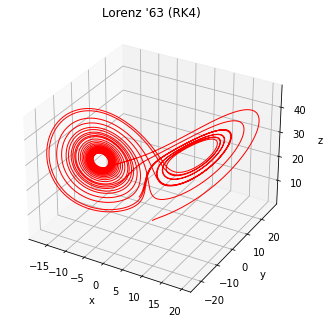

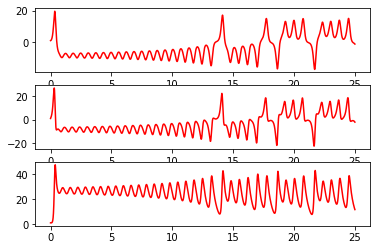

In [2]:
lorenz63_params_model  = { "p" : 10.0, "r" : 28.0, "b" : 8.0/3.0 }
#lorenz63_params_num    = { "tmax" : 25.0, "dt" : 1e-3 }
lorenz63_params_num    = { "tmax" : 25.0, "dt" : 1e-3 }
lorenz63_initial_state = [1,1,1]

lorenz63 = lorenz63.lorenz63( **lorenz63_params_model, **lorenz63_params_num )
lorenz63.setInitialState( lorenz63_initial_state )
lorenz63.simulate()
lorenz63.plot3D()
lorenz63.plot()


## Observing the True State

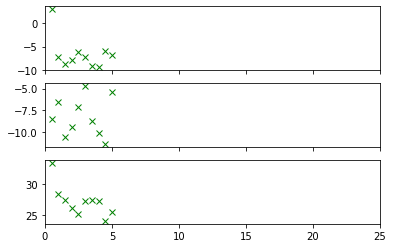

In [3]:
#obs_params = { "dt" : 0.5, "tmax" : 15.0 }
obs_params = { "dt" : 0.5, "tmax" : 5.0 }

observation = observation.observation( **obs_params )
observation.observe( lorenz63 )
observation.plot()

## Perturbing the Initial State

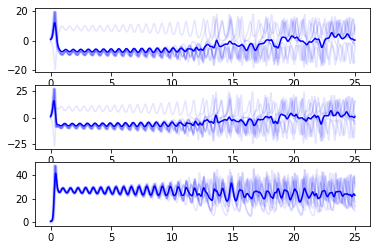

In [4]:
ensemble = ensemble.ensemble(lorenz63,10)
ensemble.simulate( )
ensemble.mean()
ensemble.plot()

## Plotting Truth, Observations and Perturbed Models

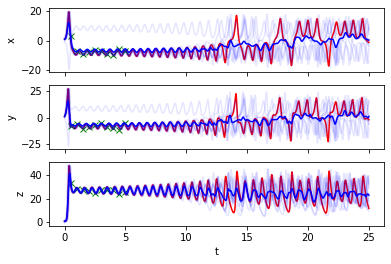

In [5]:
xyzplots = xyzplots.xyzplots( lorenz63, observation, ensemble ) 
xyzplots.plot()

## Ensemble Kalman Filtering 

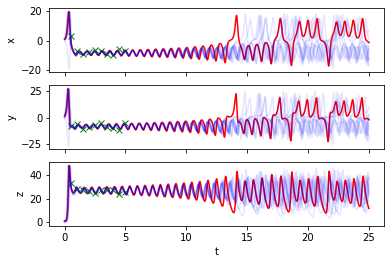

In [6]:
import filtering 
importlib.reload( filtering )

filtering = filtering.filtering( ensemble, observation, "EnKF" )
filtering.assimilate()
xyzplots.plot()